Test Accuracy: 0.8652173913043478

Classification Report:
              precision    recall  f1-score   support

         ACK       0.94      0.91      0.93       146
         BCC       0.84      0.91      0.87       169
         MEL       0.67      0.60      0.63        10
         NEV       0.90      0.88      0.89        49
         SCC       0.65      0.62      0.63        39
         SEK       0.93      0.83      0.88        47

    accuracy                           0.87       460
   macro avg       0.82      0.79      0.80       460
weighted avg       0.87      0.87      0.86       460



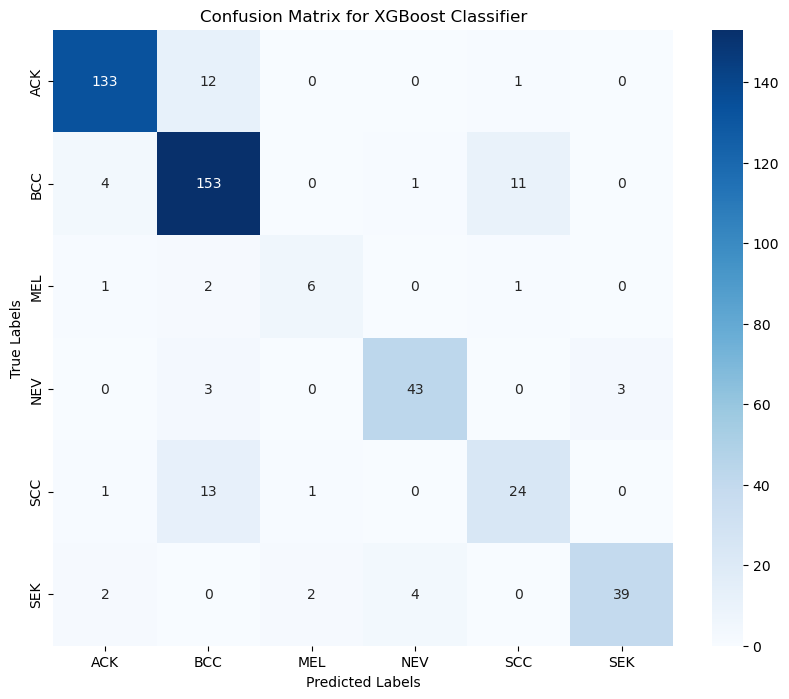


AUC Scores for Each Class:
ACK: 0.9818
BCC: 0.9627
MEL: 0.9809
NEV: 0.9901
SCC: 0.9414
SEK: 0.9890

Macro-Average AUC: 0.9743
Micro-Average AUC: 0.9826


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Read and process the data
df = pd.read_csv('../dataset/filled_with_features.csv', index_col=0, low_memory=False)

# Define function to convert booleans to strings
def convert_bool_to_str(value):
    if isinstance(value, bool):
        return "True" if value else "False"
    return value

# Apply the conversion function to each column
for col in df.columns:
    df[col] = df[col].map(convert_bool_to_str)

# Target and features
y = df['diagnostic']
df = df.drop(columns=['diagnostic'])
X_metadata = df.iloc[:, :22]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode categorical metadata
X_metadata = pd.get_dummies(X_metadata, drop_first=True)

# Scale metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data with a validation set
X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_metadata, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create sample weights for training
sample_weights = np.array([class_weights[class_id] for class_id in y_train])

# Define and train the XGBoost classifier
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train_meta, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_meta)
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK'], 
            yticklabels=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

# Calculate AUC
# Binarize the test labels for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
y_pred_proba = model.predict_proba(X_test_meta)

# Calculate AUC for each class
auc_scores = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average=None)

# Print AUC scores for each class
class_names = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
print("\nAUC Scores for Each Class:")
for class_name, auc in zip(class_names, auc_scores):
    print(f"{class_name}: {auc:.4f}")

# Macro-average AUC
macro_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"\nMacro-Average AUC: {macro_auc:.4f}")

# Micro-average AUC
micro_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='micro')
print(f"Micro-Average AUC: {micro_auc:.4f}")


Test Accuracy: 0.9456521739130435

Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.91      0.95       242
   malignant       0.91      0.98      0.94       218

    accuracy                           0.95       460
   macro avg       0.95      0.95      0.95       460
weighted avg       0.95      0.95      0.95       460



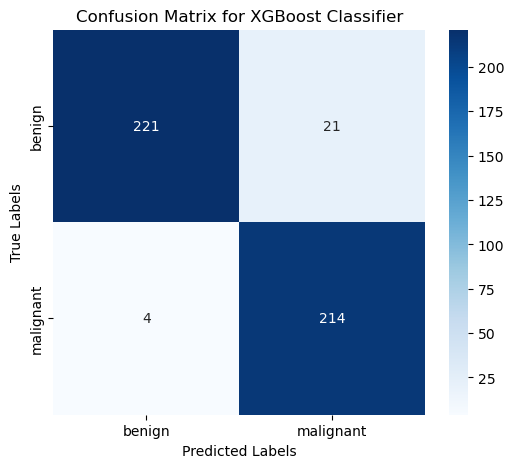


AUC Score: 0.9713


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Read and process the data
df = pd.read_csv('../dataset/filled_with_features.csv', index_col=0, low_memory=False)

# Define function to convert booleans to strings
def convert_bool_to_str(value):
    if isinstance(value, bool):
        return "True" if value else "False"
    return value

# Apply the conversion function to each column
for col in df.columns:
    df[col] = df[col].map(convert_bool_to_str)

# Target and features
y = df['diagnostic']
df = df.drop(columns=['diagnostic'])
X_metadata = df.iloc[:, :22]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Adjust encoded values
for i in range(len(y_encoded)):
    if y_encoded[i] in [1, 2, 4]:  # Malignant
        y_encoded[i] = 1
    else:  # Benign
        y_encoded[i] = 0

# One-hot encode categorical metadata
X_metadata = pd.get_dummies(X_metadata, drop_first=True)

# Scale metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data with a validation set
X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_metadata, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define and train the XGBoost classifier
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train_meta, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_meta)
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['benign', 'malignant']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

# Calculate AUC
y_pred_proba = model.predict_proba(X_test_meta)[:, 1]  # Probability of class '1' (malignant)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Print AUC
print(f"\nAUC Score: {auc_score:.4f}")
